# MINES ParisTech - PSL - Semestre 2 - Traitement du Signal
# Mini-projet groupe 2 : interpolation de données manquantes
# Judith Bellon & Louis-Justin Tallot
Contexte : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le deplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**.

En pratique, il arrive que certains capteurs soient défaillants ou encore qu'ils ne soient pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

Hypothèses : nous ferons l'hypothèse importante que les **signaux correspondent à la superposition lineaire d'ondes planes** dans les enregistrements (voir l'exemple fourni plus bas avec 3 événements).

Notions abordées : 
* Analyse des signaux après transformée de Fourier 2d
* Analyse de signaux aliasés
* Régularisation et formulation sous forme de problème inverse

Pour cela, deux approches sont considerées :
* Approche 1 : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes
* Approche 2 : suite de l'approche 1 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation

Attentes :
* Développement des approches 1 et 2 sur des données fournies ici
* Discusssion des limites des approches sur des exemples que vous pourrez créer vous-mêmes

Consignes :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels de taille lisibles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Pour la question 4
from scipy.optimize import minimize

In [2]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0, dt*(nt-1), nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0, dx*(nx-1), nx)

In [3]:
def display_data(data, titre="", x_label="Position x (m)", y_label="Time (s)", extent=None):
    fig = plt.figure()
    av = plt.subplot(111)
    
    if extent is not None:
        plt.imshow(data, extent=extent, aspect="auto")
    else:
        plt.imshow(data, aspect="auto")
        
    plt.title(titre, fontsize=14)
    av.set_ylabel(y_label, fontsize=14)
    av.set_xlabel(x_label, fontsize=14)
    vmax = np.max(np.abs(data))
    plt.clim(-vmax,vmax)
    plt.set_cmap('bwr')    

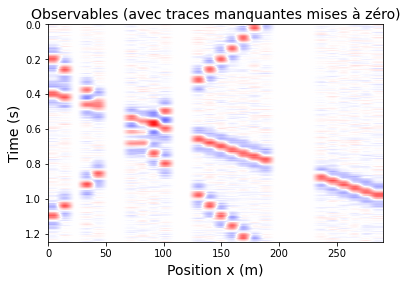

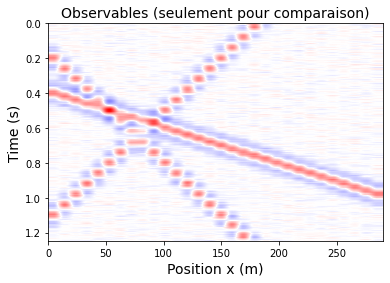

In [4]:
display_data(gpanel, 
             titre='Observables (avec traces manquantes mises à zéro)',
             extent=[ax[0],ax[-1],at[-1],at[0]]
)

display_data(panel_dense, 
             titre='Observables (seulement pour comparaison)',
             extent=[ax[0],ax[-1],at[-1],at[0]]
)

# Question 1 : analyse des données dans le domaine de Fourier 2d
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspond la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. Ne pas hésiter à zoomer dans le domaine de Fourier.

In [5]:
tf = np.fft.fftshift(np.fft.fft2(gpanel))
af1 = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
af2 = np.fft.fftshift(np.fft.fftfreq(nt, d=dt))

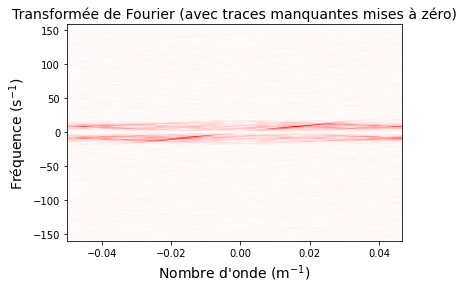

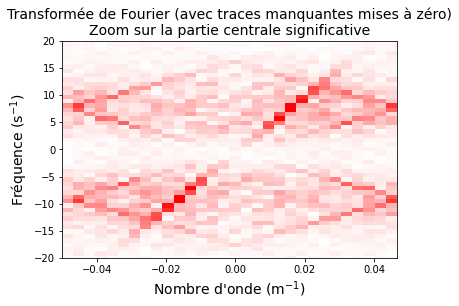

In [6]:
display_data(np.abs(tf), 
             titre='Transformée de Fourier (avec traces manquantes mises à zéro)',
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
)
display_data(np.abs(tf), 
             titre='Transformée de Fourier (avec traces manquantes mises à zéro)\nZoom sur la partie centrale significative',
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
)
plt.ylim(-20, 20);

Le nombre d'onde maximal $k = 0,05$ et la fréquence maximale $f = 150$ correspondent aux maximums que l'on peut avoir compte tenu des pas de temps et d'espace utilisés.

On remarque que l'on obtient trois directions privilégiées dans la transformée de Fourier, qui correspondent aux trois droites de l'espace $(t, x)$. Il semble que la seule droite de pente négative dans l'espace de Fourier correspond à la droite qui va "dans l'autre sens" que les deux autres. Celle qui lui est symétrique correspond à la droite qui forme un angle à peu près droit avec cette première droite. La dernière a logiquement une pente positive, plus importante.

Au bord du domaine de Fourier, on observe du repliement spectral: arrivée tout à droite (resp. à gauche) du domaine, la droite continue en fait et se retrouve par translation tout à gauche (resp. à droite), au même niveau.

# Question 2 : définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite definir un masque avec des 1 qui couvrent les événements principaux. On va supposer que les événements dans le domaine $(t,x)$ sont linéaires. Montrer qu'il en est de même dans le domaine $(f,k_x)$. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, apres avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

In [7]:
tf = np.fft.fftshift(np.fft.fft2(gpanel))
abs_data = np.abs(tf)

In [8]:
# on réalise un tableau avec des pentes qui 
# varient de manière régulière entre -300 et 300, 
# en couvrant les grandes et les petites valeurs

tableau_pentes_positif = [10/n for n in range(100, 0, -1)] \
               + [n for n in range(11, 50, 3)] \
               + [10 * n for n in range(6, 30, 2)]
tableau_pentes_negatif = list(reversed(list(map(lambda x:-x, tableau_pentes_positif))))

tableau_pentes = tableau_pentes_negatif + tableau_pentes_positif

In [9]:
# le centre est en (15, 200)
# on veut donc des droites de la forme :
# (y - 200) = pente * (x - 15)

# display_data(abs_data,
#              titre='Sommation de la transformée de Fourier sur différentes pentes',
#              x_label="Nombre d'onde (m$^{-1}$)",
#              y_label="Fréquence (s$^{-1}$)"
# )
# plt.xlim(0,29)
# plt.ylim(220, 180);


In [10]:
def sommation_pentes_data(data, plot=False):
    liste_x = np.array([x for x in range(0, 30+1)])
    if plot :
        display_data(data,
             titre='Sommation de la transformée de Fourier sur différentes pentes',
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)"
        )
        plt.xlim(0,29)
        plt.ylim(220, 180)
        
    tableau_sommation_pentes = []
    compteur= 0
    for pente in tableau_pentes:
        f, k_x = int(15*pente + 200), 0
        somme = 0
        if plot:
            plt.plot(liste_x, np.vectorize(int)(-pente*liste_x+15*pente+200), '.', color="b", linewidth=0.2)
        liste_des_kx = list(np.copy([f]))
        liste_des_f  = list(np.copy([k_x]))
        
        while True:
            if k_x > 30:
                break
            try:
                somme += data[f, k_x]
                k_x += 1
                f = int(-pente*k_x+15*pente+200)

                liste_des_kx.append(k_x)
                liste_des_f.append(f)
                
            except Exception as e:
                compteur += 1
                k_x += 1
        
        if plot:
            if len(liste_des_kx) > 1:
                plt.plot(liste_des_kx, liste_des_f, '.',color="k")

        tableau_sommation_pentes.append((pente,somme))
    
    return zip(*tableau_sommation_pentes)

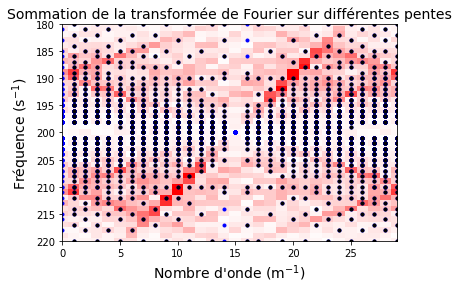

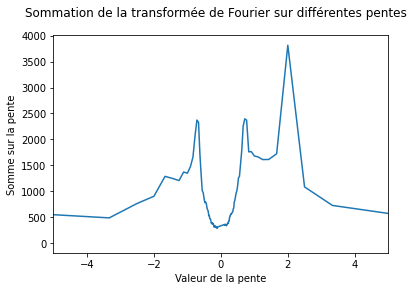

In [11]:
t_pentes, t_sommes = sommation_pentes_data(abs_data, True)

plt.figure()
plt.plot(t_pentes, t_sommes);
plt.xlim(-5, 5);
plt.suptitle("Sommation de la transformée de Fourier sur différentes pentes")
plt.gca().set_xlabel("Valeur de la pente")
plt.gca().set_ylabel("Somme sur la pente");

In [12]:
def reperage_pics(nb_peaks, t_pentes, t_sommes, plot=False, moins=5, plus=5, plot_numero=False):
    peaks = [0]*nb_peaks
    tab = np.copy(np.array(t_sommes))
    for i in range(nb_peaks):
        peaks[i] = np.argmax(tab)
        tab[peaks[i]-moins:peaks[i]+plus] = 0
    
    if plot:
        plt.plot(t_pentes, t_sommes);
        for i in range(nb_peaks):
            plt.scatter(t_pentes[peaks[i]], t_sommes[peaks[i]], color="red"); 
    if plot_numero:
        plt.figure()
        plt.plot(t_sommes);
        for i in range(nb_peaks):
            plt.scatter(peaks[i], t_sommes[peaks[i]], color="red"); 
    return peaks

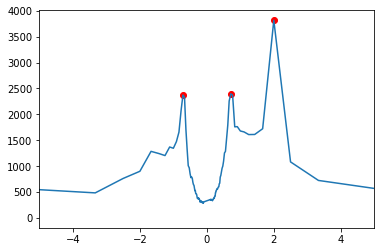

In [13]:
reperage_pics(3, *sommation_pentes_data(abs_data), plot=True)
plt.xlim(-5, 5);

In [14]:
def masquage(nb_peaks, peaks, data_shape):
    masque = np.zeros(data_shape)
    
    for i in range(nb_peaks):
        for k in range(-2, 3):  # on élargit un peu autour des pics
            pente = t_pentes[peaks[i]+k]
            f, k_x = int(15*pente + 200), 0
            while k_x < 30:
                masque[f, k_x] = 1
                k_x += 1
                f = int(-pente*k_x+15*pente+200)
                
    return np.copy(masque)

In [47]:
masque = masquage(3,
        reperage_pics(3, *sommation_pentes_data(abs_data)),
        abs_data.shape
)

# Question 3 : application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$). Si nécessaire, revenir à la question 2 pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements.

In [16]:
reconstituée = np.fft.ifft2(np.fft.ifftshift(tf))

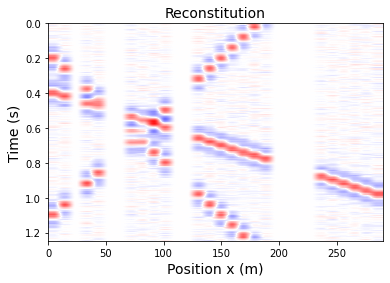

In [17]:
display_data(np.real(reconstituée),
             titre="Reconstitution", 
             extent=[ax[0],ax[-1],at[-1],at[0]]
)

In [18]:
# on applique le masque

In [19]:
tf_masquée = tf*masque
reconstituée_masquée = np.fft.ifft2(np.fft.ifftshift(tf_masquée))

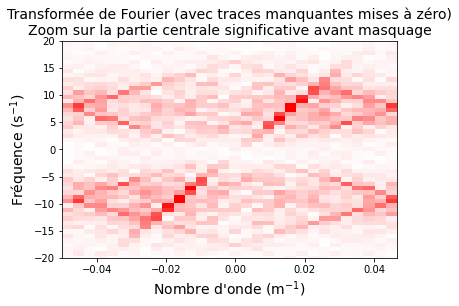

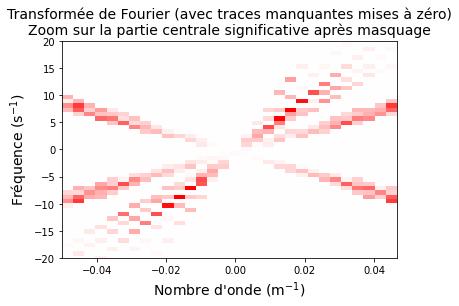

In [20]:
display_data(np.abs(tf),
             titre="Transformée de Fourier (avec traces manquantes mises à zéro)\nZoom sur la partie centrale significative avant masquage",
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
            )
plt.ylim(-20, 20)

display_data(np.abs(tf_masquée),
             titre="Transformée de Fourier (avec traces manquantes mises à zéro)\nZoom sur la partie centrale significative après masquage",
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
            )
plt.ylim(-20, 20);


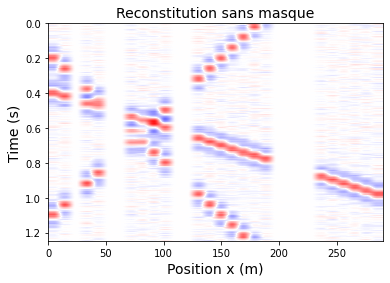

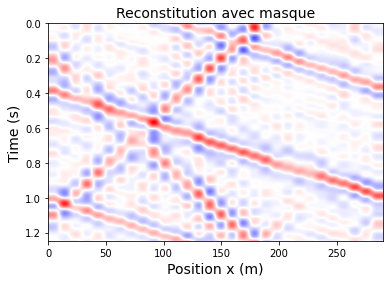

In [21]:
display_data(np.real(reconstituée), 
             titre='Reconstitution sans masque',
             extent=[ax[0],ax[-1],at[-1],at[0]]
)
display_data(np.real(reconstituée_masquée), 
             titre='Reconstitution avec masque',
             extent=[ax[0],ax[-1],at[-1],at[0]]
)

La reconstitution interpole bien les droite sur les zones initialement vides, mais cela ajoute aussi du bruit à l'image. En particulier, il y a de nouveau du repliement spectral, surtout sur la droite "la plus horizontale". Elargir la partie conservée par le masque (en prenant aussi les directions juste autour) permet de diminuerl'importance relative de cette direction par rapport aux deux autres, et donne une image qui nous semble plutôt meilleure.

# Question 4 : amélioration de l'approche 1
Le résultat de l'approche 1 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

où $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p(t,x)^\mathrm{obs}$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d. Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière iterative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposée. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)```.

$\alpha$ est une pondération dont la valeur est à tester (optimalement les deux termes ont a peu près la même valeur).

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au début du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. 

In [22]:
T = [gpanel != 0]
alpha = 0.1
T = np.reshape(T, [nt,nx])
M = np.reshape(1 - masque, [nt,nx])

def defj(p):
    """Definition of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    gpan = np.reshape(gpanel, [nt,nx])
    Fp = np.fft.fftshift(np.fft.fft2(pan))  # le masque est défini pour les données shiftées
    j0 = 1/2*np.sum((T*pan-gpan)**2) + alpha/2*np.sum(M*(np.real(Fp))**2)
    return j0


def defg(p):
    """Definition of the gradient of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    gpan = np.reshape(gpanel, [nt,nx])
    grd = np.zeros([nt,nx])
    grd += (T*pan-gpan)  # la multiplication par T transposée ne change rien ici (car T est un projecteur)
    Fp = np.fft.fftshift(np.fft.fft2(pan))
    grd += alpha*np.real(np.fft.ifft2(np.fft.ifftshift(M*Fp)))
    # Return with vector size
    return np.reshape(grd, nt*nx)


In [23]:
# Iterative mininisation (exemple)
niter = 10 # number of iterations
p0 = np.reshape(np.copy(gpanel),nt*nx)
res = minimize(defj, p0, jac=defg, method='CG', options={'disp': True, 'maxiter':niter})
# Final panel
panelf = np.reshape(res.x,[nt,nx])


         Current function value: 78878.996654
         Iterations: 4
         Function evaluations: 75
         Gradient evaluations: 63


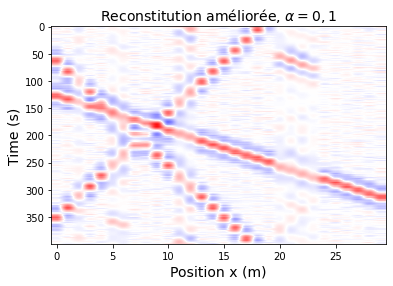

In [24]:
vmax = np.max(np.real(panelf))
display_data(np.real(panelf),
             titre=r'Reconstitution améliorée, $\alpha = 0,1$'
)

On remarque que quand on augmente beaucoup $\alpha$, on retrouve à peu près le résultat de l'approche précédente: en effet, comme on cherche moins à avoir le bon résultat sur les zones connues, la deuxième partie de l'optimisation prend le dessus et selectionne les pentes choisies dans la transformée de Fourier, quitte à avoir du repliement.

Au contraire, si on prend $\alpha$ très petit, on reconstitue exactement l'image de départ, avec les trous, puisqu'on ne filtre plus la transformée de Fourier.

Entre les deux, on peut trouver de bons compromis, par exemple $\alpha = 0,1$ me paraît donner des résultats assez satisfaisants: cela complète les signaux tout en gardant un bruit raisonnable autour. 

# Question 5 : analyse des limites de l'approche
Proposer une analyse des limites des approches 1 et 2, par exemple au travers d'applications sur des données bruitées, qui contiennent des événements qui ne sont pas linéaires, pourquoi pas sur des images dans un contexte très différent. **Cette dernière partie est très ouverte, et j'attends des investigations possiblement très variées.**


Essayons tout d'abord de produire un enregistrement contenant des événements paraboliques.

In [25]:
parabolic_panel = np.zeros(gpanel.shape)
for time in range(gpanel.shape[0]):
    for space in range(gpanel.shape[1]):
#         expr = -100 +time -(space-5)*(space-20)
        expr1 = -20+space - 0.001*(time-50)*(time-300)
        expr2 = space +0.001*(time-100)*(time-350)
        
        if (-1 <= expr1) and ( expr1 <= 1):
            parabolic_panel[time, space] = 1
        if (-1 <= expr2) and ( expr2 <= 1):
            parabolic_panel[time, space] = -1

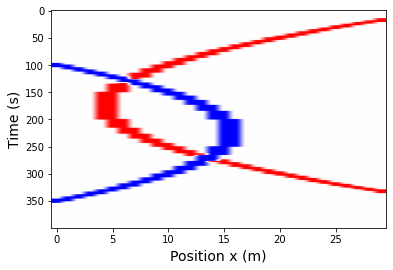

In [26]:
# on la visualise
display_data(parabolic_panel)

In [27]:
parabolic_panel_missing = np.copy(parabolic_panel)

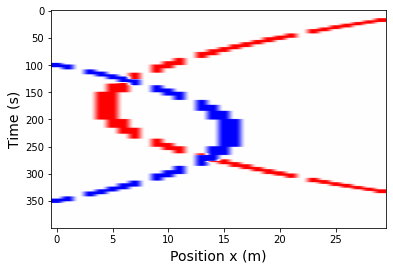

In [28]:
for time in range(gpanel.shape[0]):
    for space in [2, 8, 12, 22]:
        parabolic_panel_missing[time, space] = 0

display_data(parabolic_panel_missing)

In [29]:
tf_para = np.fft.fftshift(np.fft.fft2(parabolic_panel_missing))

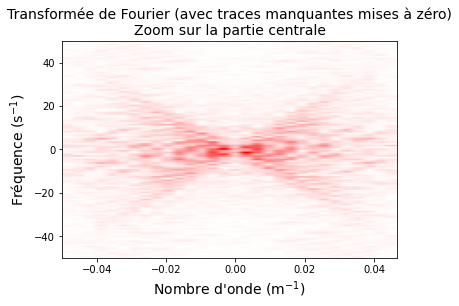

In [30]:
display_data(np.abs(tf_para), 
             titre='Transformée de Fourier (avec traces manquantes mises à zéro)\nZoom sur la partie centrale',
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
)
plt.ylim(-50, 50);

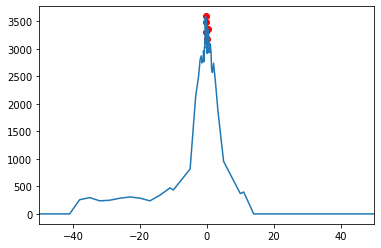

In [31]:
nb_pics = 5
masque = masquage(nb_pics,
                  reperage_pics(nb_pics, 
                                *sommation_pentes_data(np.abs(tf_para)), 
                                                       plot=True, 
                                                       moins=30, 
                                                       plus=30),
                  abs_data.shape
)
plt.xlim(-50,50);

On voit que la fonction reperage_pics a de la difficulté à trouver les bons pics. En effet, nous voyons en observant la transformée de Fourier qu'il n'y a pas de direction prédominante dans celle-ci.

[50, 84, 199, 114, 166]



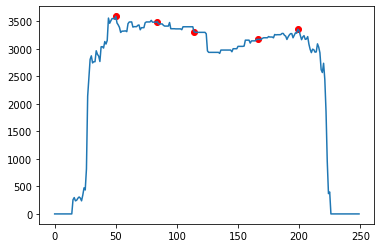

In [32]:
print(reperage_pics(nb_pics, 
              *sommation_pentes_data(np.abs(tf_para)), 
              plot_numero=True, 
              moins=30, 
              plus=30
), end="\n\n")
# plt.xlim(0,50);

In [33]:
# masque = masquage(1, [25], abs_data.shape)

In [34]:
reconstituée_para = np.fft.ifft2(np.fft.ifftshift(tf_para))
reconstituée_masquee_para = np.fft.ifft2(np.fft.ifftshift(tf_para*masque))

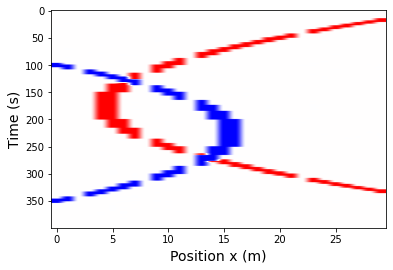

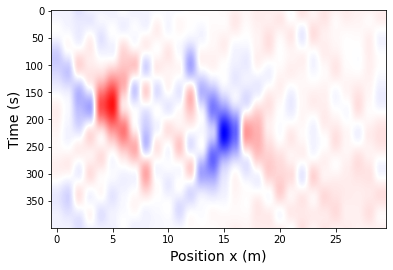

In [35]:
display_data(np.real(reconstituée_para))
display_data(np.real(reconstituée_masquee_para))

Nous voyons donc qu'il est difficile de reconstituer avec cette approche le signal originel.

Essayons maintenant avec des événements plus proches de ceux pour lesquels cette approche a été construite : prenons des droites ainsi que des lignes brisées.

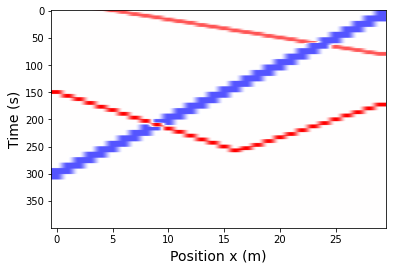

In [36]:
linear_panel = np.zeros(gpanel.shape)
for time in range(gpanel.shape[0]):
    for space in range(gpanel.shape[1]):
#         expr = -100 +time -(space-5)*(space-20)
        expr1 = -20+space - 0.3*(time-50)#*(time-300)
        expr2 = -20+space +0.1*(time-100)
        expr3 = +30+2*space - 0.3*(time-50) if space<=16 else -95+2*space + 0.3*(time-50)
        
        
        if (-1 <= expr1) and ( expr1 <= 1):
            linear_panel[time, space] = 2
        if (-1 <= expr2) and ( expr2 <= 1):
            linear_panel[time, space] = -2
        if (-1 <= expr3) and ( expr3 <= 1):
            linear_panel[time, space] = 3
display_data(linear_panel)

In [37]:
linear_panel_missing = np.copy(linear_panel)

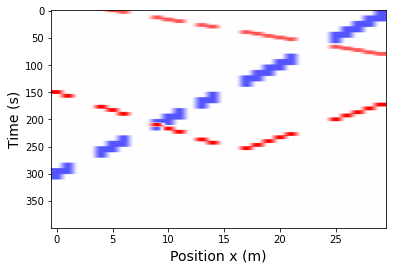

In [38]:
for time in range(gpanel.shape[0]):
    for space in [2, 3, 7, 8, 12, 15, 16, 22, 23, 24]:
        linear_panel_missing[time, space] = 0

display_data(linear_panel_missing)

In [39]:
tf_para = np.fft.fftshift(np.fft.fft2(linear_panel_missing))

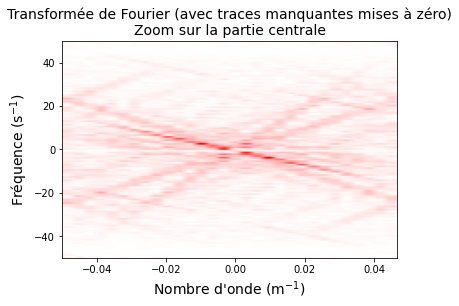

In [40]:
display_data(np.abs(tf_para), 
             titre='Transformée de Fourier (avec traces manquantes mises à zéro)\nZoom sur la partie centrale',
             x_label="Nombre d'onde (m$^{-1}$)",
             y_label="Fréquence (s$^{-1}$)",
             extent=[af1[0],af1[-1],af2[0],af2[-1]]
)
plt.ylim(-50, 50);

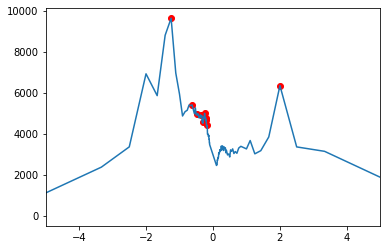

In [41]:
nb_pics = 10
masque = masquage(nb_pics,
                  reperage_pics(nb_pics, 
                                *sommation_pentes_data(np.abs(tf_para)), 
                                                       plot=True), 
#                                                        moins=30, 
#                                                        plus=40),
                  abs_data.shape
)
plt.xlim(-5,5);

In [42]:
reconstituée_para = np.fft.ifft2(np.fft.ifftshift(tf_para))
reconstituée_masquee_para = np.fft.ifft2(np.fft.ifftshift(tf_para*masque))

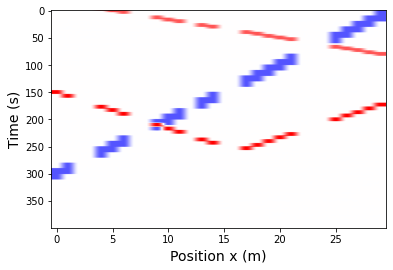

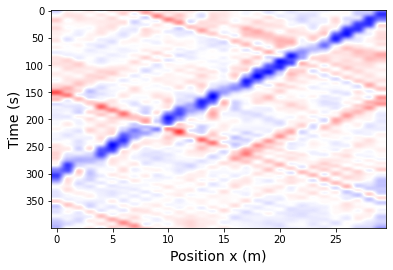

In [43]:
display_data(np.real(reconstituée_para))
display_data(np.real(reconstituée_masquee_para))

Nous voyons que pour ce signal, la première approche donne des résultats assez intéressants. La droite bleue est bien complétée (puisqu'il s'agit bien d'un événement linéaire). Pour la ligne brisée, il est intéressant de voir qu'une partie est complétée, mais en bleu plutôt qu'en rouge... Par ailleurs, on constate que la première direction de cette ligne est prolongée, ce qui paraît assez logique : cette direction a du être sélectionnée dans le masque.

 Comme sur l'exemple précédent, il y a beaucoup de bruit autour de l'image, il serait peut-être intéressant de recalibrer le masque pour cet exemple.
 
Nous allons alors essayer d'appliquer la deuxième approche.

In [54]:
T = [linear_panel_missing != 0]
alpha = 10
T = np.reshape(T, [nt,nx])
M = np.reshape(1 - masque, [nt,nx])

def defj(p):
    """Definition of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    gpan = np.reshape(linear_panel_missing, [nt,nx])
    Fp = np.fft.fftshift(np.fft.fft2(pan))  # le masque est défini pour les données shiftées
    j0 = 1/2*np.sum((T*pan-gpan)**2) + alpha/2*np.sum(M*(np.real(Fp))**2)
    return j0


def defg(p):
    """Definition of the gradient of the objective function"""
    # Retrieve the size
    pan = np.reshape(p,[nt,nx])
    gpan = np.reshape(linear_panel_missing, [nt,nx])
    grd = np.zeros([nt,nx])
    grd += (T*pan-gpan)  # la multiplication par T transposée ne change rien ici (car T est un projecteur)
    Fp = np.fft.fftshift(np.fft.fft2(pan))
    grd += alpha*np.real(np.fft.ifft2(np.fft.ifftshift(M*Fp)))
    # Return with vector size
    return np.reshape(grd, nt*nx)

In [55]:
# Iterative mininisation (exemple)
niter = 10 # number of iterations
p0 = np.reshape(np.copy(linear_panel_missing),nt*nx)
res = minimize(defj, p0, jac=defg, method='CG', options={'disp': True, 'maxiter':niter})
# Final panel
panelf = np.reshape(res.x,[nt,nx])

         Current function value: 604912.316873
         Iterations: 3
         Function evaluations: 47
         Gradient evaluations: 36


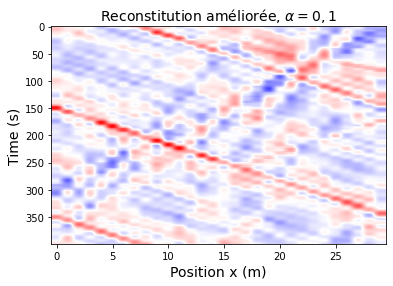

In [56]:
vmax = np.max(np.real(panelf))
display_data(np.real(panelf),
             titre=r'Reconstitution améliorée, $\alpha = 0,1$'
)

Ici, la deuxième approche semble surtout ajouter du bruit dans l'image, sans vraiment améliorer la reconstitution des signaux. Nous avons retesté plusieurs valeurs de $\alpha$, aucune ne nous a semblé vraiment convaincante.